In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn import svm
from sklearn import metrics
import sklearn.neighbors as knn
from tqdm import tqdm

import utils
import applicability_domain as ad

%load_ext autoreload
%autoreload 2

print(tf.version.VERSION)
print("# of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    gpu = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpu[0], True)

2.1.0
# of GPUs Available:  1


In [2]:
# load MNIST dataset
# normalize data to 0~1 range
data = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

x_train = np.pad(x_train, ((0,0), (2,2), (2,2)), 'constant', constant_values=0)
x_train = x_train / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 32, 32, 1))
print(x_train.shape)
print(y_train.shape)

x_test = np.pad(x_test, ((0,0), (2,2), (2,2)), 'constant', constant_values=0)
x_test = x_test / 255.
x_test = np.reshape(x_test, (x_test.shape[0], 32, 32, 1))
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
print(x_test.shape)
print(y_test.shape)

(60000, 32, 32, 1)
(60000,)
(10000, 32, 32, 1)
(10000,)


In [3]:
# load pre-trained LeNet-5 model
model_path = 'models/lenet5.h5'
model_dir = os.path.dirname(model_path)
lenet5_model = keras.models.load_model(model_dir)
lenet5_model.summary()

Model: "lenet5_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hand_writing_digit (InputLay [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
pool_1 (AveragePooling2D)    (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
pool_2 (AveragePooling2D)    (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               4

In [4]:
probability_model = tf.keras.Sequential([
    lenet5_model,
    tf.keras.layers.Softmax()
])

probability_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lenet5_mlp (Model)           (None, 10)                61706     
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
_________________________________________________________________


In [5]:
def get_predictions(x):
    pred = probability_model(x)
    indices = np.argmax(pred, axis=1)
    scores = np.max(pred, axis=1)
    return np.append([indices], [scores], axis=0).T

In [6]:
# test prediction
pred = get_predictions(x_test[:5])
print(y_test[:5])
print(pred[:,0])
pred

[7 2 1 0 4]
[7. 2. 1. 0. 4.]


array([[7.        , 1.        ],
       [2.        , 1.        ],
       [1.        , 0.99999821],
       [0.        , 0.99999988],
       [4.        , 0.99992013]])

In [7]:
print(x_test.shape)
print(y_test.shape)
loss, acc = lenet5_model.evaluate(x_test, y_test, verbose=2)

(10000, 32, 32, 1)
(10000,)
10000/10000 - 0s - loss: 0.0434 - accuracy: 0.9898


In [8]:
# split model into encoder (convolutional layers) and dense-layer neural network
# create encoder
inputs = keras.Input(shape=(32,32,1), name='hand_writing_digit')
x = keras.layers.Conv2D(filters=6, kernel_size=(5,5), activation='relu', name='conv2d_1')(inputs)
x = keras.layers.AveragePooling2D((2,2), name='pool_1')(x)
x = keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', name='conv2d_2')(x)
x = keras.layers.AveragePooling2D((2,2), name='pool_2')(x)
x = keras.layers.Flatten(name='flatten')(x)
outputs = keras.layers.Dense(120, activation='relu', name='dense_1')(x)

encoder = keras.Model(inputs, outputs, name='lenet5_encoder')

# load weights and loack the trained weights
for encoder_layer, lenet5_layer in zip(encoder.layers, lenet5_model.layers[:7]):
    encoder_layer.set_weights(lenet5_layer.get_weights())
    encoder_layer.trainable = False

# we don't compile encoder, since there's nothing to train the results are in the middel of LeNet-5
encoder.summary()

Model: "lenet5_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hand_writing_digit (InputLay [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
pool_1 (AveragePooling2D)    (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
pool_2 (AveragePooling2D)    (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)            

In [9]:
# check weights
for encoder_layer, lenet5_layer in zip(encoder.layers, lenet5_model.layers[:7]):
    if len(encoder_layer.get_weights()) is not 0:
        result = np.array_equal(
            encoder_layer.get_weights()[0],
            lenet5_layer.get_weights()[0])
        if result is not True:
            raise Exception('Unmatched weights')

print('Passed layer comparision test')

Passed layer comparision test


In [10]:
# create dense-layer model
inputs = keras.Input(shape=(120,), name='encoded_img')
x = keras.layers.Dense(84, activation='relu', name='dense_2')(inputs)
outputs = keras.layers.Dense(10, name='outputs')(x)

dense_nn_model = keras.Model(inputs, outputs, name='dense_nn')

# load weights and loack the trained weights
for empty_layer, lenet5_layer in zip(dense_nn_model.layers[1:], lenet5_model.layers[-2:]):
    empty_layer.set_weights(lenet5_layer.get_weights())
    empty_layer.trainable = False

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

dense_nn_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy'])

dense_nn_model.summary()

Model: "dense_nn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_img (InputLayer)     [(None, 120)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
_________________________________________________________________
outputs (Dense)              (None, 10)                850       
Total params: 11,014
Trainable params: 0
Non-trainable params: 11,014
_________________________________________________________________


In [11]:
# check weights
for clone_layer, lenet5_layer in zip(dense_nn_model.layers[1:], lenet5_model.layers[-2:]):
    if len(encoder_layer.get_weights()) is not 0:
        result = np.array_equal(
            clone_layer.get_weights()[0],
            lenet5_layer.get_weights()[0])
        if result is not True:
            raise Exception('Unmatched weights')

print('Passed layer comparision test')

Passed layer comparision test


In [12]:
# use the coder and dense_nn models together
lenet5_test_acc = 0.9898

encoded_test = encoder.predict(x_test)
loss, acc = dense_nn_model.evaluate(encoded_test, y_test, verbose=2)

if not math.isclose(lenet5_test_acc, acc, rel_tol=1e-6):
    raise Exception('Unmatched accuracy')

10000/10000 - 0s - loss: 0.0434 - accuracy: 0.9898


## Create Adversarial examples using FGSM
https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

In [13]:
# use probability loss function instead of scalar
loss_fn_adv = keras.losses.CategoricalCrossentropy()

def create_adversarial_perturbation(input_img, input_probs):
    if input_img.shape != (32, 32, 1):
        raise Exception('Image size does not match', input_img.shape)
    if input_probs.shape != (1, 10):
        raise Exception('Probabilities should be a row vector', input_probs.shape)
    
    x = tf.convert_to_tensor([input_img])
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = lenet5_model(x)
        loss = loss_fn_adv(input_probs, pred)
    
    gradient = tape.gradient(loss, x)
    signed_grad = tf.sign(gradient)
    return signed_grad

3079
Ture label: 7
Prediction: [[7. 1.]]


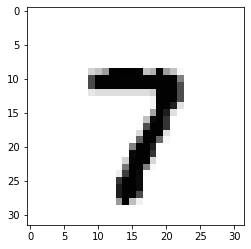

In [14]:
# testing
# idx = np.random.randint(0, len(y_test))
idx = 3079
print(idx)
print('Ture label:', y_test[idx])
pred = get_predictions(np.array([x_test[idx]]))
print('Prediction:', pred)
plt.figure()
plt.imshow(x_test[idx,:,:,0], cmap='Greys', vmin=0, vmax=1.0)

In [15]:
img = x_test[idx]
# use prediction from the model instead of true label
pred = lenet5_model(tf.convert_to_tensor([img]))
perturbation = create_adversarial_perturbation(img, pred)

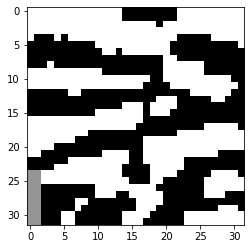

In [16]:
plt.figure()
plt.imshow(perturbation[0,:,:,0], cmap='Greys', vmin=-1., vmax=1.)

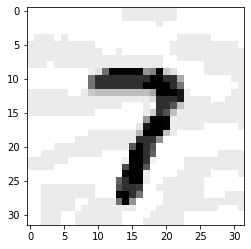

In [17]:
epsilon = 0.15
adv_x = img + epsilon * perturbation
# limited range to 0 and 1
adv_x = tf.clip_by_value(adv_x, 0, 1)

plt.figure()
plt.imshow(adv_x[0,:,:,0], cmap='Greys')

In [18]:
probs = probability_model(tf.convert_to_tensor([img]))
pred = get_predictions(tf.convert_to_tensor([img]))
# print(*probs.numpy()[0])
print('Prediction on clean image (label, prob.):', pred[0])

adv_prbos = probability_model(adv_x)
adv_pred = get_predictions(tf.convert_to_tensor(adv_x))
# print(*adv_prbos.numpy()[0])
print('Prediction on adversarial example (label, prob.):', adv_pred[0])

if pred[0][0] != adv_pred[0][0]:
    print('Successfully found adversarial example')
else:
    print(f'Failed to find adversarial example from index {idx}')

Prediction on clean image (label, prob.): [7. 1.]
Prediction on adversarial example (label, prob.): [9.         0.75023264]
Successfully found adversarial example


In [19]:
# try to load saved file
folder_path = os.getcwd()
adv_path = folder_path + '/data/saved_adv.npy'
adv_dir = os.path.dirname(adv_path)
print(adv_dir)
if not os.path.exists(adv_dir):
    os.mkdir(adv_dir)

/home/lukec/workspace/jupyter_tensorflow/data


In [20]:
# creating adversarial examples on entire test set
count = len(y_test)
adv_test = np.empty((0, 32, 32, 1), dtype=np.float32)
pred_test = lenet5_model(tf.convert_to_tensor(x_test))
epsilon = 0.15

if not os.path.isfile(adv_path):
    with tqdm(total=count) as pbar:
        for i in range(count):
            pred_og = tf.convert_to_tensor([pred_test[i]])
            perturbation = create_adversarial_perturbation(x_test[i], pred_og)
            perturbation = perturbation.numpy()[0]
            adv = x_test[i] + epsilon * perturbation

            # apply clipping
            # adv = tf.clip_by_value(adv, 0, 1)
            adv_test = np.append(adv_test, [adv], axis=0)
            if i % 10 == 0:
                pbar.update(10)
    np.save(adv_path, adv_test)
else:
    adv_test = np.load(adv_path, mmap_mode='r')

adv_test.shape
# loss, acc = lenet5_model.evaluate(adv_test[:50], y_test[:50], verbose=2)

(10000, 32, 32, 1)

In [21]:
print('Evaluate the adversarial examples set')
loss, acc = lenet5_model.evaluate(adv_test, y_test[:count], verbose=2)

Evaluate the adversarial examples set
10000/10000 - 0s - loss: 1.7135 - accuracy: 0.8017


In [22]:
# this variable combines the predicted label and its probability
adv_pred_label = get_predictions(adv_test)
adv_pred_label[:5]

array([[7.        , 0.99999869],
       [2.        , 0.99999702],
       [1.        , 0.99896634],
       [0.        , 1.        ],
       [9.        , 0.9999913 ]])

In [23]:
# Stage 1 - Applicability
print('\n---------- Applicability ---------------')
print('Note: Instead of block it, we use this step to clip and rescale the inputs.')
# apply clipping
ad_test = tf.clip_by_value(adv_test, 0., 1.)

# apply 8-bit rescaling
ad_test = tf.round(ad_test * 255.) / 255.
print(ad_test.shape)


---------- Applicability ---------------
Note: Instead of block it, we use this step to clip and rescale the inputs.
(10000, 32, 32, 1)


In [24]:
print('After applicability transform:')
loss, acc = lenet5_model.evaluate(ad_test, y_test, verbose=2)

pred_passed = np.array(get_predictions(ad_test)[:, 0], dtype=np.uint8)
conf_mat = metrics.confusion_matrix(y_test, pred_passed)
count_mis = len(np.where(np.not_equal(y_test, pred_passed))[0])
print(f'\n# of missclassified = {count_mis}')

print('\nConfusion matrix')
print('Actual classes')
print(' ', *list(range(10)), sep='   ')
print(conf_mat)

After applicability transform:
10000/10000 - 0s - loss: 0.8054 - accuracy: 0.8724

# of missclassified = 1276

Confusion matrix
Actual classes
    0   1   2   3   4   5   6   7   8   9
[[ 945    0    7    0    2    2    8    2    2   12]
 [   0 1104    5   10    2    0    5    5    4    0]
 [   7    7  951   11    1    0    1   52    2    0]
 [   0    2    6  914    0   69    0    5    2   12]
 [   0    1    1    0  713    0    8    0    0  259]
 [   2    0    0   48    0  766   13    0    9   54]
 [  10    0    6    0   20   40  882    0    0    0]
 [   0    1   11    4    6    0    0  746    1  259]
 [   1    4   14   25    4   47   10    2  853   14]
 [   0    0    0   19  118    6    1   12    3  850]]


In [25]:
# Stage 2 - Reliability
# parameters for Reliability Stage
k = 12
zeta = 0.4 

print('\n---------- Reliability -----------------')
print(f'Parameters: k = {k}, zeta = {zeta}')


---------- Reliability -----------------
Parameters: k = 12, zeta = 0.4


In [26]:
# the clean train set after encoding
encoded_train = encoder.predict(x_train)
encoded_ad = encoder.predict(ad_test)

knn_models = []
# mu, sd, and are scalar for each label
means = np.empty((10), dtype=np.float32)
std_devs = np.empty((10), dtype=np.float32)

num_labels = 10
with tqdm(total=num_labels) as pbar:
    for i in range(num_labels):
        indices = np.where(y_train == i)
        # creating kNN models for each class
        knn_model = utils.unimodal_knn(encoded_train[indices], k)
        knn_models.append(knn_model)

        # computing mean, standard deviation and threshold
        mu, sd = utils.get_distance_info(
            knn_models[i], encoded_train[indices], k, seen_in_train_set=True)
        means[i] = mu
        std_devs[i] = sd
        
        pbar.update(1)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [27]:
# for easier to adjust zeta
# threshold is a scalar for each label
thresholds = np.empty((10), dtype=np.float32)

for i in range(10):
    thresholds[i] = ad.get_reliability_threshold(mu, sd, zeta)

In [28]:
encoded_passed_s2, indices_passed_s2 = ad.check_reliability(
    encoded_ad,
    predictions=adv_pred_label[:,0],
    models=knn_models,
    dist_thresholds=thresholds,
    classes=list(range(10)),
    verbose=0
)
print(encoded_passed_s2.shape)
print(indices_passed_s2.shape)

(3114, 120)
(3114,)


In [29]:
# Stage 2 result
loss, acc = lenet5_model.evaluate(
    ad_test.numpy()[indices_passed_s2], 
    y_test[indices_passed_s2], 
    verbose=2)

print('\nAfter reliability check:')
print(f'Blocked {len(adv_test) - len(indices_passed_s2)} samples')
pass_rate = utils.get_rate(encoded_passed_s2, adv_test)
print(f'Pass rate = {pass_rate * 100:.4f}%')

pred_passed = np.array(get_predictions(ad_test.numpy()[indices_passed_s2])[:,0], dtype=np.uint8)
conf_mat = metrics.confusion_matrix(y_test[indices_passed_s2], pred_passed)
count_mis = len(np.where(np.not_equal(y_test[indices_passed_s2], pred_passed))[0])
print(f'\n# of missclassified = {count_mis}')

print('\nConfusion matrix')
print('Actual classes')
print(' ', *list(range(10)), sep='   ')
print(conf_mat)

3114/3114 - 0s - loss: 0.3306 - accuracy: 0.9663

After reliability check:
Blocked 6886 samples
Pass rate = 31.1400%

# of missclassified = 105

Confusion matrix
Actual classes
    0   1   2   3   4   5   6   7   8   9
[[495   0   0   0   0   0   0   0   0   0]
 [  0 848   1   0   0   0   2   1   4   0]
 [  0   0  15   0   0   0   0   1   1   0]
 [  0   0   0 104   0   1   0   0   1   0]
 [  0   0   0   0 176   0   2   0   0  45]
 [  0   0   0   0   0  19   1   0   0   0]
 [  2   0   0   0   0   0 407   0   0   0]
 [  0   0   0   0   0   0   0 163   0  19]
 [  0   1   0   1   0   0   0   0 372   1]
 [  0   0   0   0  15   0   0   4   2 410]]


In [30]:
# Stage 3 - Decidability
# parameters for Decidability Stage
k2 = 24

ad_left = np.copy(ad_test.numpy()[indices_passed_s2])
y_left = np.copy(y_test[indices_passed_s2])
pred_left = np.array(get_predictions(ad_left)[:,0], dtype=np.uint8)
encoded_left = np.copy(encoded_ad[indices_passed_s2])

print('\n---------- Decidability ----------------')
print(f'Parameters: k = {k2}')


---------- Decidability ----------------
Parameters: k = 24


In [31]:
# the knnn model with complete train set
comp_knn_model = knn.KNeighborsClassifier(
    n_neighbors=k2,
    n_jobs=-1,
    weights='distance'
)
comp_knn_model.fit(encoded_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=24, p=2,
                     weights='distance')

In [32]:
comp_knn_model.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [33]:
pred = comp_knn_model.predict(encoded_test)
score = metrics.accuracy_score(y_test, pred)
print(f'Accuracy of KNN on clean test set  = {score*100:.4f}%')
# Note: the KNN model on encoded attributes has surpassed LeNet-5

pred = comp_knn_model.predict(encoded_ad)
score = metrics.accuracy_score(y_test, pred)
print(f'Accuracy of KNN on adversarial set  = {score*100:.4f}%')

Accuracy of KNN on clean test set  = 99.2000%
Accuracy of KNN on adversarial set  = 90.5300%


In [34]:
pred_passed = get_predictions(ad_test.numpy()[indices_passed_s2])
print('sample passed in:', pred_passed.shape)

encoded_passed_s3, indices_passed_s3 = ad.check_decidability(
    encoded_left,
    pred_left,
    comp_knn_model
)
indices_passed_s3 = indices_passed_s3[0]

print(encoded_passed_s3.shape)
print(indices_passed_s3.shape)

sample passed in: (3114, 2)
(3109, 120)
(3109,)


In [35]:
# Stage 3 result
ad_left_s3 = np.copy(ad_left[indices_passed_s3])
y_left_s3 = np.copy(y_left[indices_passed_s3])
pred_left_s3 = np.array(get_predictions(ad_left_s3)[:,0], dtype=np.uint8)

loss, acc = lenet5_model.evaluate(
    ad_left_s3, 
    y_left_s3, 
    verbose=2)

print('\nAfter decidability check:')
print(f'Blocked {len(indices_passed_s2) - len(indices_passed_s3)} samples')

pass_rate = utils.get_rate(indices_passed_s3, indices_passed_s2)
print(f'Pass rate on 3rd stage = {pass_rate * 100:.4f}%')
pass_rate = utils.get_rate(encoded_passed_s3, adv_test)
print(f'Pass rate overall = {pass_rate * 100:.4f}%')

print(f'\n# of samples after AD = {len(indices_passed_s3)}')
print(f'Total blocked samples = {len(y_test) - len(indices_passed_s3)}')

3109/3109 - 0s - loss: 0.3295 - accuracy: 0.9669

After decidability check:
Blocked 5 samples
Pass rate on 3rd stage = 99.8394%
Pass rate overall = 31.0900%

# of samples after AD = 3109
Total blocked samples = 6891


In [36]:
conf_mat = metrics.confusion_matrix(y_left_s3, pred_left_s3)
indices_mis = np.where(np.not_equal(y_left_s3, pred_left_s3))[0]
count_mis = len(indices_mis)
print(f'# of missclassified = {count_mis}')

print('\nConfusion matrix')
print('Actual classes')
print(' ', *list(range(10)), sep='   ')
print(conf_mat)

# of missclassified = 103

Confusion matrix
Actual classes
    0   1   2   3   4   5   6   7   8   9
[[495   0   0   0   0   0   0   0   0   0]
 [  0 848   1   0   0   0   2   1   3   0]
 [  0   0  15   0   0   0   0   1   1   0]
 [  0   0   0 104   0   1   0   0   1   0]
 [  0   0   0   0 175   0   2   0   0  45]
 [  0   0   0   0   0  19   1   0   0   0]
 [  2   0   0   0   0   0 405   0   0   0]
 [  0   0   0   0   0   0   0 163   0  19]
 [  0   1   0   0   0   0   0   0 372   1]
 [  0   0   0   0  15   0   0   4   2 410]]


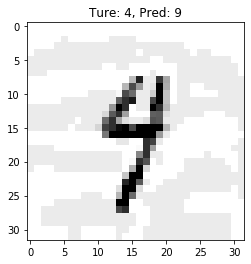

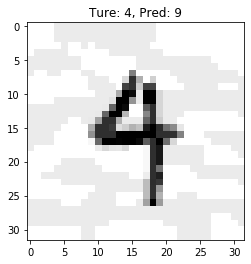

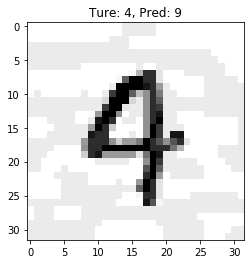

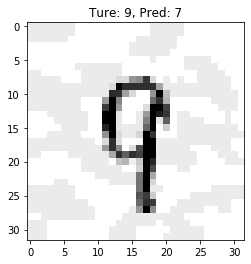

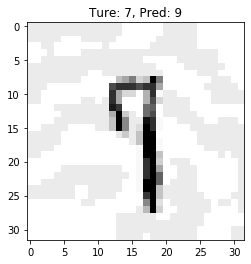

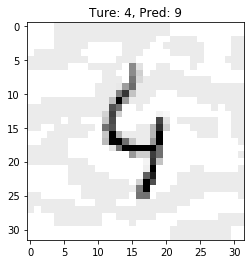

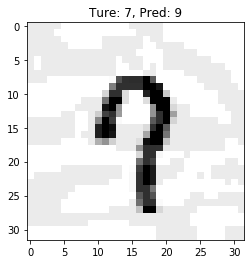

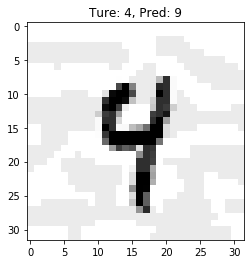

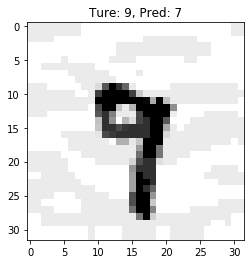

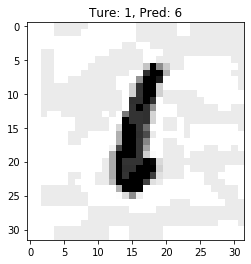

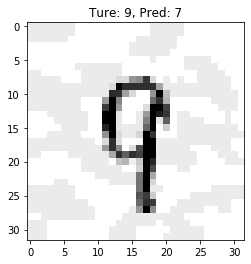

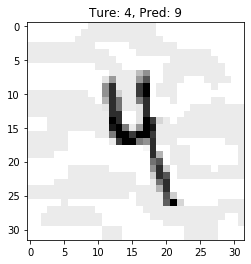

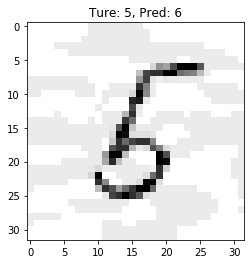

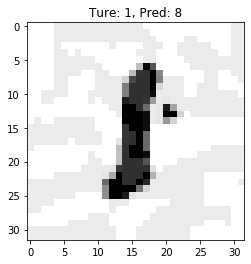

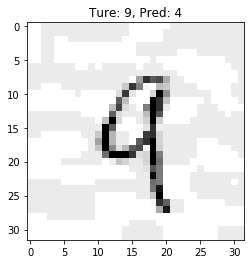

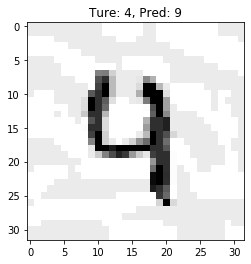

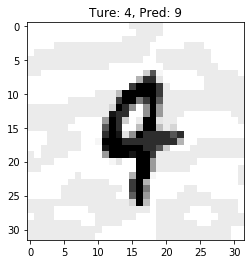

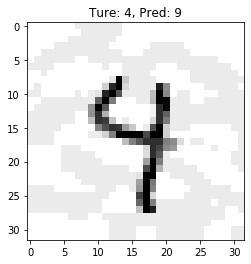

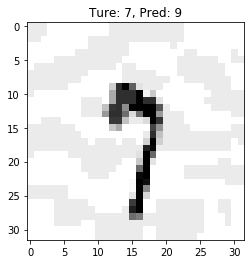

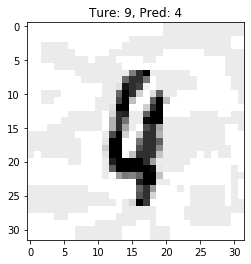

In [37]:
selected = np.random.randint(0, len(indices_mis), 20)

for i in indices_mis[selected]:
    plt.figure()
    plt.title(f'Ture: {y_left_s3[i]}, Pred: {pred_left_s3[i]}')
    plt.imshow(ad_left_s3[i,:,:,0], cmap='Greys')